In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import h5py
import sys
import os

In [46]:
# Define root directory
# root = os.path.dirname(os.path.abspath(__file__))
root = "."

for r in range(0, 268):

    # Load pickle
    pathogen_code, file, column = pickle.load(open(os.path.join(root, "..", "tmp", "models_to_train.pkl"), "rb"))[r]
    print("Pathogen: " + str(pathogen_code) + "\n" + str(file) + " -- " + str(column))

    # Load assays
    assays = pd.read_csv(os.path.join(root, "..", "output", pathogen_code, "assays.csv"))
    assay_organism = set(assays[assays['target_type'] == 'ORGANISM']['assay_id'])

    if file.split("_")[0] not in assay_organism:
        print("Skipping, not organism assay\n\n")
        continue

    # Load data
    data = pd.read_csv(os.path.join(root, "..", "output", pathogen_code, "datasets", file))
    X = data['canonical_smiles'].astype(str).tolist()
    Y = data['bin'].astype(np.int8).to_numpy()
    print(f"Actives: {sum(Y==1)}; Inactives: {sum(Y==0)}")

    if len(np.where(Y == 1)[0]) < 10:
        print("Skipping, not enough actives\n\n")
        continue
    if len(np.where(Y == 0)[0]) < 10:
        print("Skipping, not enough inactives\n\n")
        continue

    # Define stratified 4 fold CV
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Load descriptors
    with h5py.File(os.path.join(root, "..", "output", pathogen_code, "descriptors.h5"), "r") as f:
        SMILES = f['SMILES'][:]
        X_Morgan = f['X_Morgan'][:]
        ### add here rdkit descriptors

    # Define dict mapping smiles to morgan fingerprints
    SMILES_TO_MORGAN = {
        smiles.decode("utf-8"): fp
        for (chembl_id, smiles), fp in zip(SMILES, X_Morgan)}

    # For each split
    AUROCS = []
    for c, (train, test) in enumerate(skf.split(X, Y)):

        # Get train/test indices
        X_train, Y_train = [X[i] for i in train], Y[train]
        X_test, Y_test = [X[i] for i in test], Y[test]

        # Get Morgan Fingerprints and train model
        X_train = np.array([SMILES_TO_MORGAN[smi] for smi in X_train])
        X_test  = np.array([SMILES_TO_MORGAN[smi] for smi in X_test])
        clf = RandomForestClassifier(n_estimators=50, n_jobs=8, random_state=42)
        clf.fit(X=X_train, y=Y_train)

        # Store results
        auroc = round(roc_auc_score(Y_test, clf.predict_proba(X_test)[:, 1]), 3)
        AUROCS.append(auroc)

    # Save CV results
    print(file, " -- ", round(np.mean(AUROCS), 3), "±", round(np.std(AUROCS), 3))
    print("\n\n")
    with open(os.path.join(root, "..", "output", pathogen_code, "models", file.replace('.gz', '')), "w") as outfile:
        outfile.write(",".join([str(i) for i in AUROCS]))

    # Train full model
    X = np.array([SMILES_TO_MORGAN[smi] for smi in X])
    clf = RandomForestClassifier(n_estimators=50, n_jobs=8, random_state=42)
    clf.fit(X=X, y=Y)

    # Save model
    pickle.dump(clf, open(os.path.join(root, "..", "output", pathogen_code, "models", file.replace(".csv.gz", ".pkl")), "wb"))

Pathogen: mtuberculosis
CHEMBL4649948_PERCENTEFFECT_%_perc_1.csv.gz -- bin
Skipping, not organism assay


Pathogen: mtuberculosis
CHEMBL4649948_PERCENTEFFECT_%_perc_5.csv.gz -- bin
Skipping, not organism assay


Pathogen: mtuberculosis
CHEMBL4649948_PERCENTEFFECT_%_perc_10.csv.gz -- bin
Skipping, not organism assay


Pathogen: mtuberculosis
CHEMBL4649948_PERCENTEFFECT_%_expcutoff_50.csv.gz -- bin
Skipping, not organism assay


Pathogen: mtuberculosis
CHEMBL4649948_PERCENTEFFECT_%_expcutoff_90.csv.gz -- bin
Skipping, not organism assay


Pathogen: mtuberculosis
CHEMBL4649949_PERCENTEFFECT_%_perc_1.csv.gz -- bin
Skipping, not organism assay


Pathogen: mtuberculosis
CHEMBL4649949_PERCENTEFFECT_%_perc_5.csv.gz -- bin
Skipping, not organism assay


Pathogen: mtuberculosis
CHEMBL4649949_PERCENTEFFECT_%_perc_10.csv.gz -- bin
Skipping, not organism assay


Pathogen: mtuberculosis
CHEMBL4649949_PERCENTEFFECT_%_expcutoff_50.csv.gz -- bin
Skipping, not organism assay


Pathogen: mtuberculosis
CH

In [74]:
all_assays = sorted(os.listdir(os.path.join(root, "..", "output", pathogen_code, "models")))
assays = sorted(set(["_".join(i.split("_")[:3]) for i in all_assays]))

In [103]:
model_to_aurocs = {}
for assay in assays:
    models = [i for i in all_assays if assay in i and 'csv' in i]
    for model in models:
        aurocs = open(os.path.join(root, "..", "output", pathogen_code, "models", model), "r").read().split(",")
        model_to_aurocs[model] = [float(i) for i in aurocs]

In [147]:
def get_color(label):
    if "perc" in label:
        return "#8DC7FA"
    else:
        return "#FAA08B"

In [148]:
ind = np.argsort([np.mean(np.array([model_to_aurocs[j] for j in all_assays if i in j and 'csv' in j]).flatten()) for i in assays])

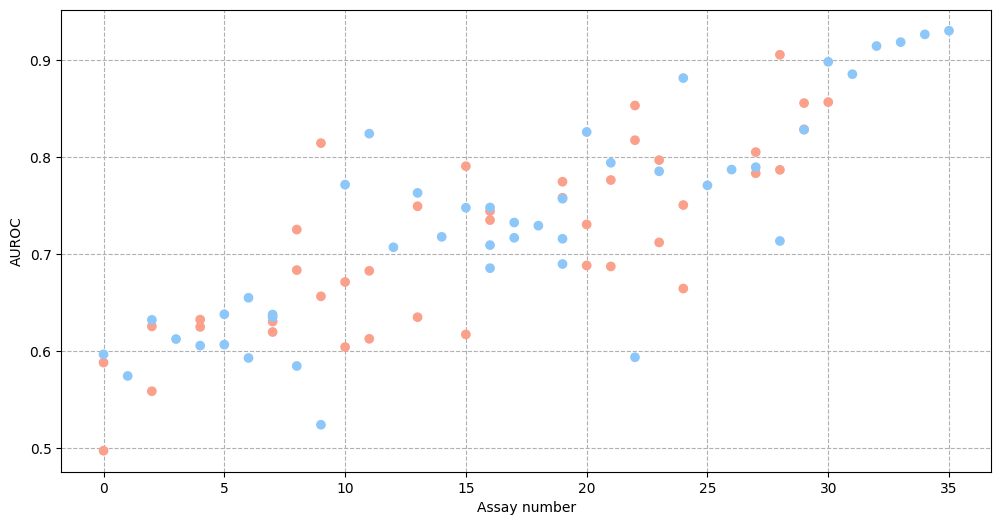

In [174]:
plt.figure(figsize=(12, 6))
x, y, colors = [], [], []
TOP = []
for c, assay in enumerate(np.array(assays)[ind]):
    models = [i for i in all_assays if assay in i and 'csv' in i]
    x.extend([c]*len(models))
    y.extend([np.mean(model_to_aurocs[model]) for model in models])
    colors.extend([get_color(model) for model in models])
    if len([i for i in models if 'expcutoff' in i]) > 0:
        TOP.append(sorted(models, key = lambda x: -np.mean(model_to_aurocs[x]))[0])

plt.scatter(x, y, c=colors, zorder=2)
plt.ylabel("AUROC")
plt.xlabel("Assay number")
plt.grid(linestyle='--')
plt.show()

In [166]:
TOP

['CHEMBL3832777_MIC_umol.L-1_perc_10.csv',
 'CHEMBL3832764_MIC_umol.L-1_perc_10.csv',
 'CHEMBL3832763_MIC_umol.L-1_expcutoff_5.csv',
 'CHEMBL4649971_IC50_umol.L-1_perc_5.csv',
 'CHEMBL1049618_MIC_umol.L-1_expcutoff_5.csv',
 'CHEMBL3832766_MIC_umol.L-1_expcutoff_5.csv',
 'CHEMBL3832767_MIC_umol.L-1_perc_10.csv',
 'CHEMBL3832772_MIC_umol.L-1_perc_10.csv',
 'CHEMBL3832765_MIC_umol.L-1_perc_10.csv',
 'CHEMBL3832770_MIC_umol.L-1_expcutoff_5.csv',
 'CHEMBL4649961_PERCENTEFFECT_%_perc_1.csv',
 'CHEMBL4649971_PERCENTEFFECT_%_expcutoff_50.csv',
 'CHEMBL3832771_MIC_umol.L-1_perc_10.csv',
 'CHEMBL3832769_MIC_umol.L-1_perc_10.csv',
 'CHEMBL1634497_MIC_umol.L-1_expcutoff_5.csv',
 'CHEMBL3832768_MIC_umol.L-1_expcutoff_5.csv',
 'CHEMBL3832773_MIC_umol.L-1_perc_10.csv',
 'CHEMBL2032580_MIC_umol.L-1_expcutoff_10.csv',
 'CHEMBL4333704_MIC_umol.L-1_expcutoff_10.csv',
 'CHEMBL1839643_MIC_umol.L-1_expcutoff_10.csv',
 'CHEMBL4384699_MIC_umol.L-1_perc_10.csv']

In [171]:
len(TOP)

21

In [173]:
len([i for i in TOP if 'perc' in i]), len([i for i in TOP if 'expcutoff' in i])

(11, 10)